### Objective

In [1]:
!pip install bs4
!pip install requests
!pip install selenium
!pip install nltk
!pip install scikit-plot
!pip install vaderSentiment
!pip install emoji


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 
nltk.download("stopwords")
nltk.download('omw-1.4')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Webscraping the data from flipkart website

#### Preprocessing

In [3]:
df=pd.read_csv('Flipkartdata.csv')
df

,Unnamed: 0,Customer Name,Rating,Comment,Review
0,0,NaN,4.3,NaN,NaN
1,1,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...
15659,15659,NaN,NaN,NaN,NaN
15660,15660,NaN,NaN,NaN,NaN
15661,15661,NaN,NaN,NaN,NaN
15662,15662,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15664 entries, 0 to 15663
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     15664 non-null  int64  
 1   Customer Name  9119 non-null   object 
 2   Rating         10054 non-null  float64
 3   Comment        9119 non-null   object 
 4   Review         9119 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 612.0+ KB


In [5]:
df.isnull().sum()

Unnamed: 0          0
Customer Name    6545
Rating           5610
Comment          6545
Review           6545
dtype: int64

In [6]:
df.dropna(inplace=True)
df.drop(['Unnamed: 0','Customer Name','Rating','Comment'],axis=1,inplace=True)
df.reset_index(inplace=True,drop=True)
df

,Review
0,Nice mobile 👍👍and ossam picture qualityREAD MORE
1,Nice phone 📱 for this price. All features is g...
2,This mobile is awesomeREAD MORE
3,Good cameraREAD MORE
4,"In this price point good performance,and camer..."
...,...
9114,Nice product 👍READ MORE
9115,Super volume moneyREAD MORE
9116,So goodREAD MORE
9117,GoodREAD MORE


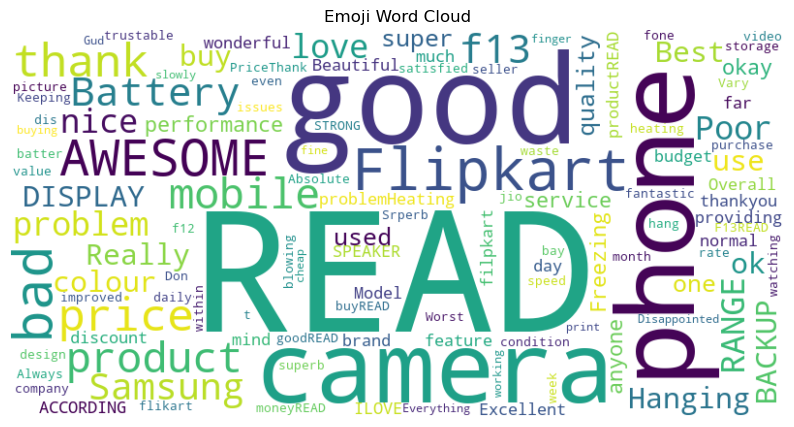

In [7]:
emoji_text = ' '.join(review for review in df['Review'] if any(char in review for char in ('😃', '😞', '👎', '❤️', '🎉')))

# Create a WordCloud object
wordcloud = WordCloud(
    width=800, height=400, background_color='white'
).generate(emoji_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Emoji Word Cloud')
plt.show()


In [8]:
print(df.shape ,df.drop_duplicates().shape,df.drop_duplicates(subset='Review').shape)

(9119, 1) (4229, 1) (4229, 1)


In [9]:
def clean_sent(text):
  #tokenization and case conversion
  token=word_tokenize(text.lower())
  #token--->list of tokens
  #removing non alpha char
  ftoken=[i for i in token if i.isalpha()]
  #ftoken-----> list
  sw=stopwords.words("english")
  stokens=[i for i in ftoken if i not in sw]
  #stokens--->list
  #lemmatization
  lemma=WordNetLemmatizer()
  ltoken=[lemma.lemmatize(i) for i in stokens]
  #ltoken--->list
  #joining all tokens
  return " ".join(ltoken)

In [10]:
df['Review']=df['Review'].astype('str')
df['Review']=df['Review'].apply(clean_sent)
df

,Review
0,nice mobile ossam picture qualityread
1,nice phone price feature goodread
2,mobile awesomeread
3,good cameraread
4,price point good performance camera totally worth
...,...
9114,nice product
9115,super volume moneyread
9116,goodread
9117,goodread


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


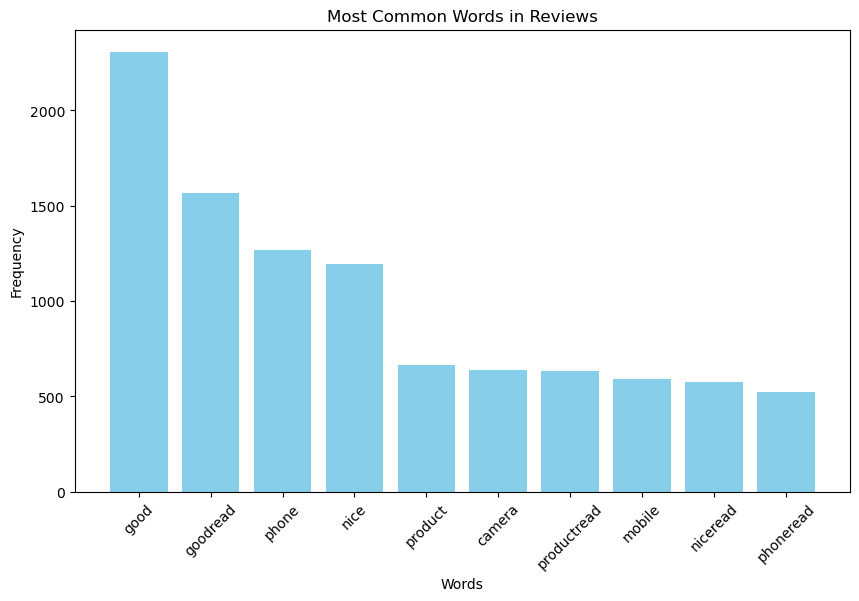

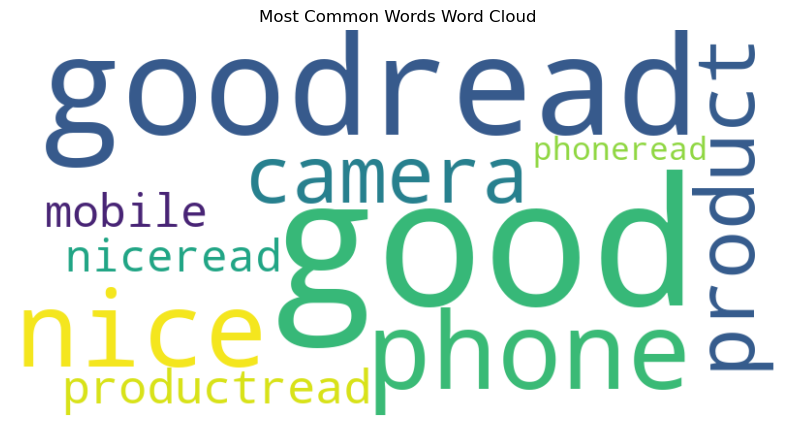

In [11]:
all_text = ' '.join(df['Review'])

# Tokenize words and remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
words = nltk.word_tokenize(all_text)
filtered_words = [word for word in words if word.lower() not in stop_words]

# Count the occurrences of each word
word_counts = Counter(filtered_words)

# Get the most common words and their frequencies
common_words = word_counts.most_common(10)
common_words_dict = dict(common_words)

# Create a bar plot for the most common words
plt.figure(figsize=(10, 6))
plt.bar(common_words_dict.keys(), common_words_dict.values(), color='skyblue')
plt.title('Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Create a WordCloud object for the most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words_dict)

# Display the word cloud for most common words
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words Word Cloud')
plt.show()

In [12]:
def get_sentiment_score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(sentence)
    return sentiment_score



# Apply sentiment analysis and scoring to the 'Review' column
df['Sentiment_Score'] = df['Review'].apply(get_sentiment_score)

# Extract the compound score (overall sentiment score) from the sentiment scores
df['Sentiment'] = df['Sentiment_Score'].apply(lambda score: 'positive' if score['compound'] >= 0.05 else ('neutral' if -0.05 < score['compound'] < 0.05 else 'negative'))

# Display the DataFrame with sentiment and sentiment scores
print(df)

                                                 Review  \
0                 nice mobile ossam picture qualityread   
1                     nice phone price feature goodread   
2                                    mobile awesomeread   
3                                       good cameraread   
4     price point good performance camera totally worth   
...                                                 ...   
9114                                       nice product   
9115                             super volume moneyread   
9116                                           goodread   
9117                                           goodread   
9118                                   nycc productread   

                                        Sentiment_Score Sentiment  
0     {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...  positive  
1     {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...  positive  
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   neutral  
3     {'neg': 0.0, 

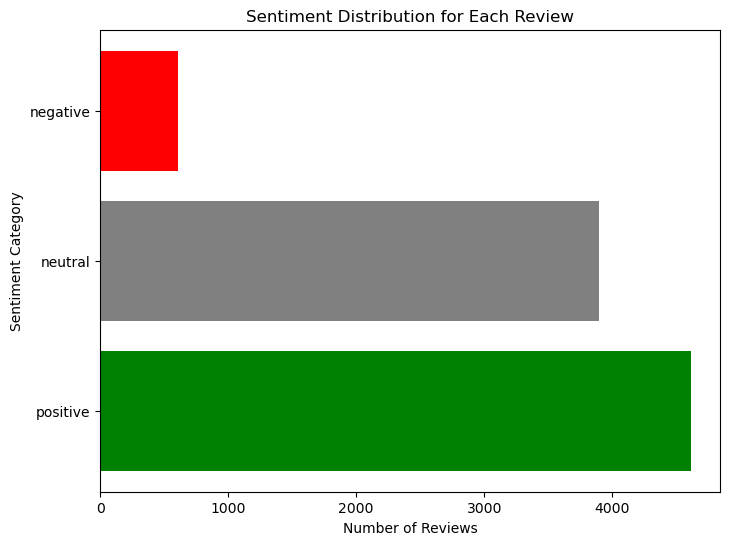

In [13]:
sentiment_counts = df['Sentiment'].value_counts()

# Create a horizontal bar plot of sentiment distribution
plt.figure(figsize=(8, 6))
colors = ['green', 'gray', 'red']
plt.barh(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment Category')
plt.title('Sentiment Distribution for Each Review')
plt.show()


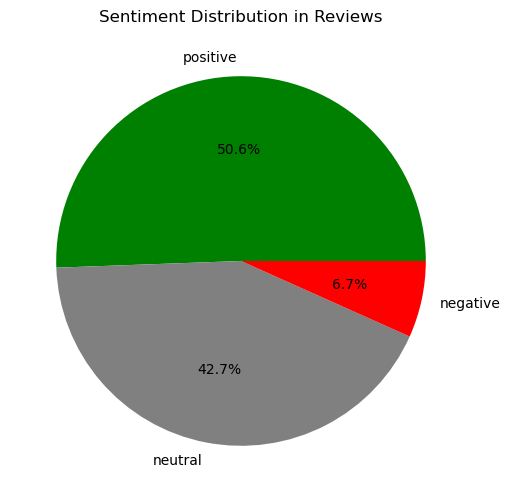

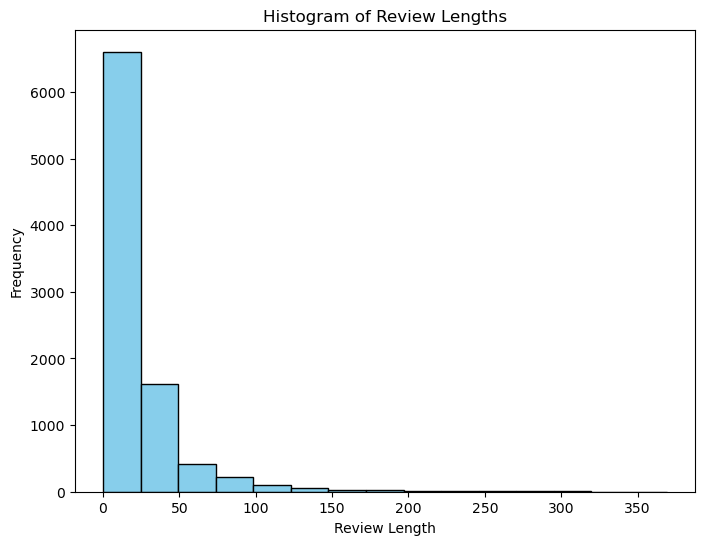

In [14]:
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'gray', 'red'])
plt.title('Sentiment Distribution in Reviews')
plt.show()

# Calculate review lengths
df['ReviewLength'] = df['Review'].apply(lambda x: len(x))

# Create a histogram of review lengths
plt.figure(figsize=(8, 6))
plt.hist(df['ReviewLength'], bins=15, color='skyblue', edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


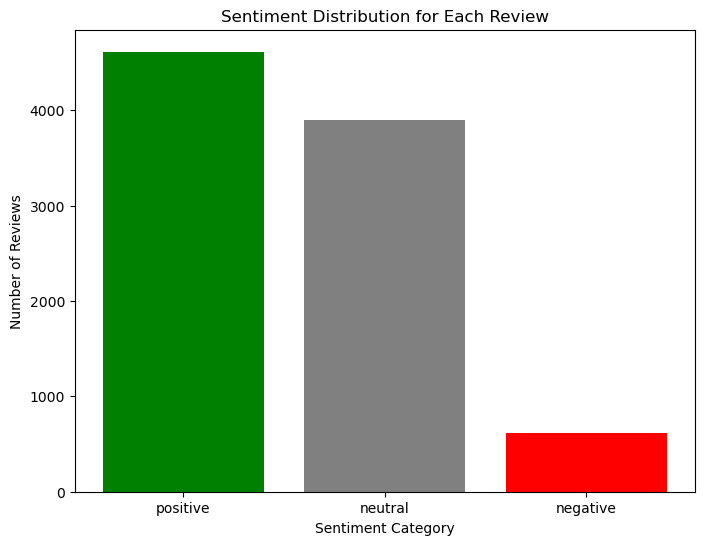

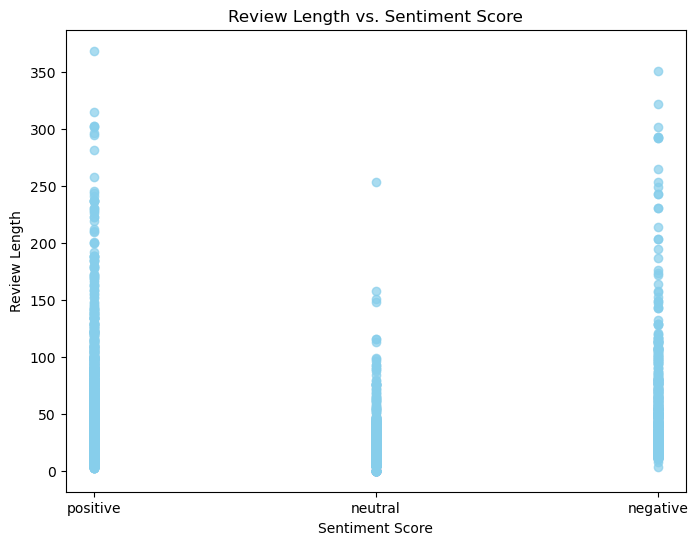

In [15]:
nltk.download('vader_lexicon')

sentiment_counts = df['Sentiment'].value_counts()

# Create a stacked bar plot of sentiment distribution for each review
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts, color=['green', 'gray', 'red'])
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Distribution for Each Review')
plt.show()

# Create a scatter plot of review length vs. sentiment score
plt.figure(figsize=(8, 6))
plt.scatter(df['Sentiment'], df['Review'].apply(len), color='skyblue', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Review Length')
plt.title('Review Length vs. Sentiment Score')
plt.show()


In [16]:
print((df['Sentiment'].value_counts(normalize=True)*100))

positive    50.575721
neutral     42.723983
negative     6.700296
Name: Sentiment, dtype: float64


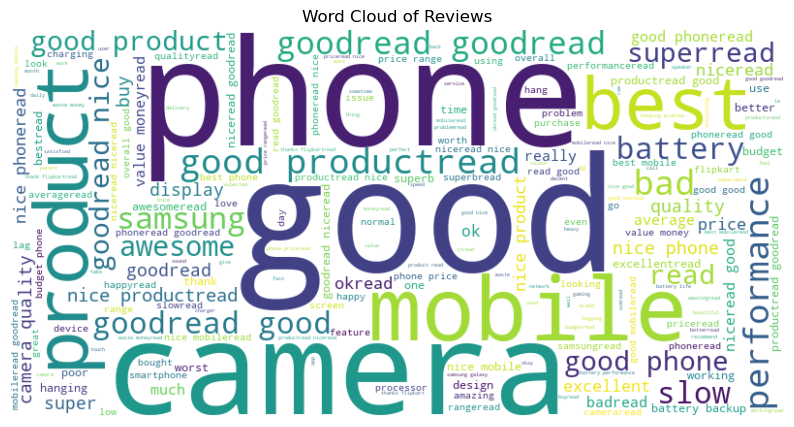

In [17]:
all_reviews = ' '.join(df['Review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()


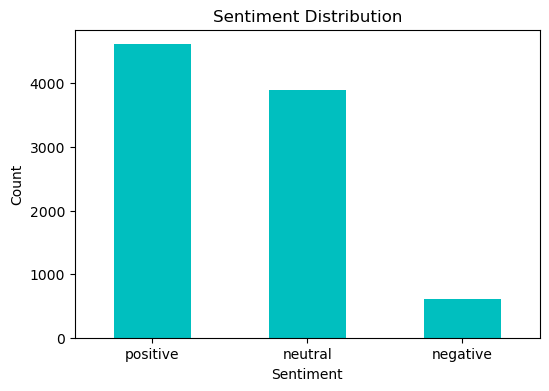

In [18]:
plt.figure(figsize=(6, 4))
df['Sentiment'].value_counts().plot(kind='bar', color='c')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


<Axes: ylabel='Sentiment'>

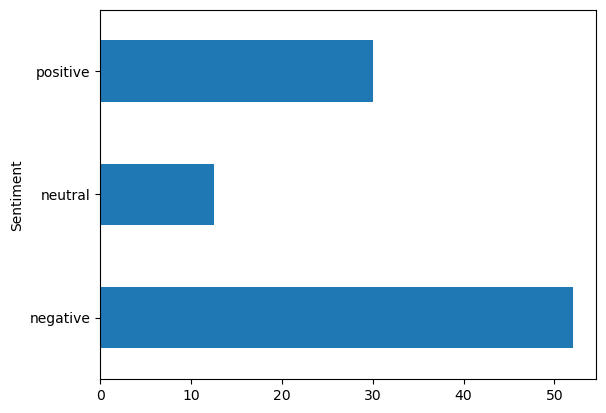

In [19]:
df['num_characters'] = df['Review'].apply(lambda x:len(x))
df
df.groupby('Sentiment')['num_characters'].mean().plot(kind='barh')

<Axes: ylabel='Sentiment'>

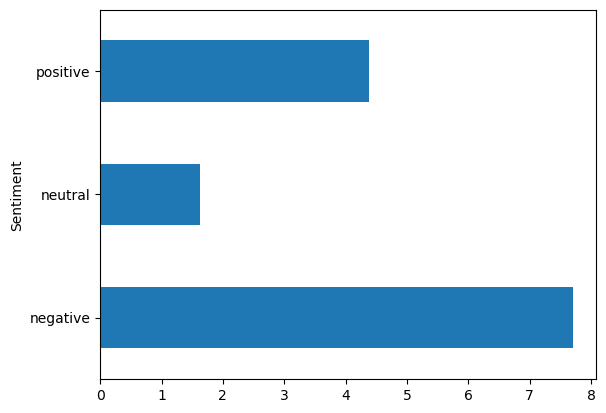

In [20]:
df['num_words'] = df['Review'].apply(lambda x:len(nltk.word_tokenize(x)))
df
df.groupby('Sentiment')['num_words'].mean().plot(kind='barh')

<Axes: ylabel='Sentiment'>

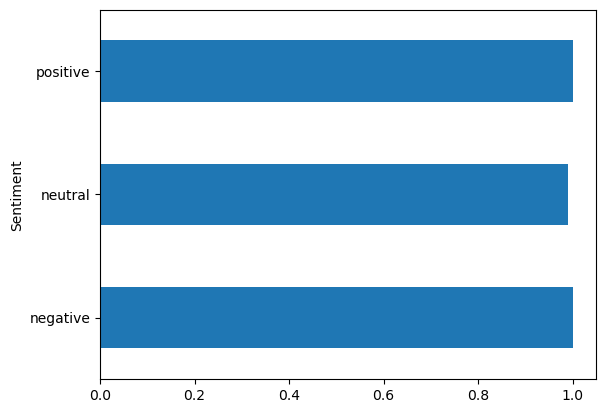

In [21]:
df['num_sentences'] = df['Review'].apply(lambda x:len(nltk.sent_tokenize(x)))
df
df.groupby('Sentiment')['num_sentences'].mean().plot(kind='barh')

In [22]:
df[['num_characters','num_words','num_sentences']].describe()


,num_characters,num_words,num_sentences
count,9119.000000,9119.000000,9119.000000
mean,24.065139,3.429104,0.996052
std,29.384651,4.413954,0.062711
min,0.000000,0.000000,0.000000
25%,8.000000,1.000000,1.000000
50%,15.000000,2.000000,1.000000
75%,26.000000,4.000000,1.000000
max,369.000000,53.000000,1.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


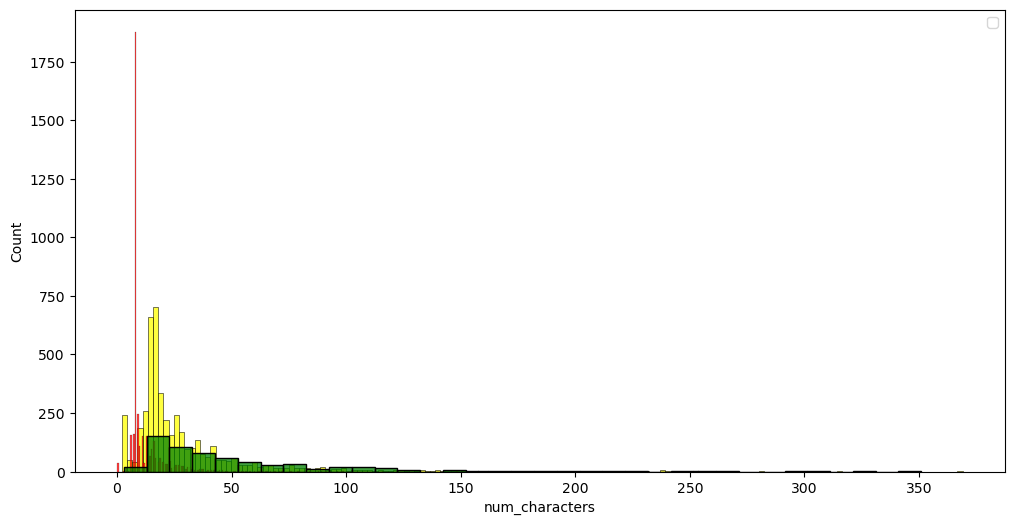

In [23]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['Sentiment'] == 'positive']['num_characters'],color='yellow')
sns.histplot(df[df['Sentiment'] == 'neutral']['num_characters'],color='red')
sns.histplot(df[df['Sentiment'] == 'negative']['num_characters'],color='green')

plt.legend()

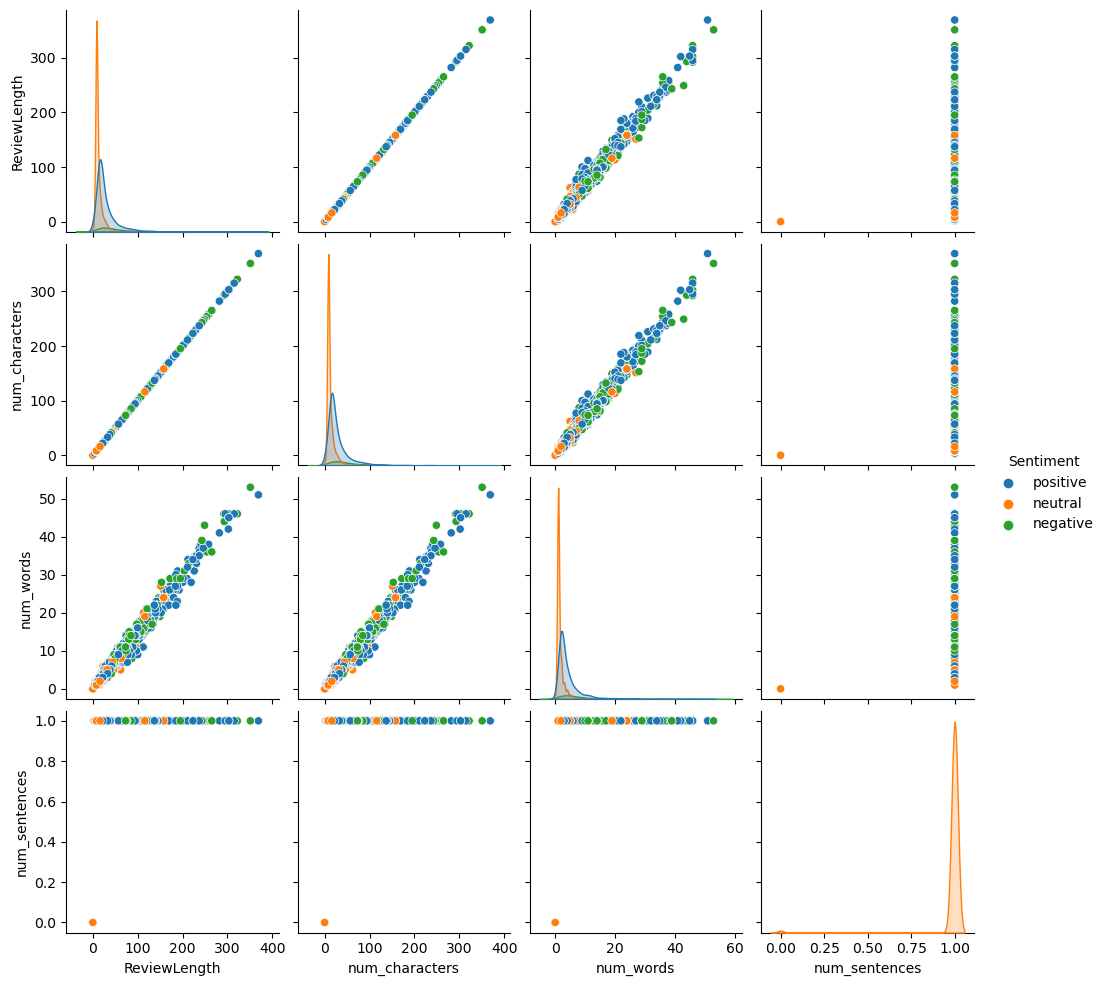

In [24]:
sns.pairplot(df,hue='Sentiment')

In [25]:
df

,Review,Sentiment_Score,Sentiment,ReviewLength,num_characters,num_words,num_sentences
0,nice mobile ossam picture qualityread,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",positive,37,37,5,1
1,nice phone price feature goodread,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",positive,33,33,5,1
2,mobile awesomeread,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,18,18,2,1
3,good cameraread,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",positive,15,15,2,1
4,price point good performance camera totally worth,"{'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...",positive,49,49,7,1
...,...,...,...,...,...,...,...
9114,nice product,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",positive,12,12,2,1
9115,super volume moneyread,"{'neg': 0.0, 'neu': 0.339, 'pos': 0.661, 'comp...",positive,22,22,3,1
9116,goodread,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,8,8,1,1
9117,goodread,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,8,8,1,1


In [26]:
print((df['Sentiment'].value_counts(normalize=True)*100))

positive    50.575721
neutral     42.723983
negative     6.700296
Name: Sentiment, dtype: float64


#### Preprocessing: Convert sentiment labels to numeric values


In [27]:
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

### Building ML Model

In [28]:
X = df['Review']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Define a list of classifiers to try
classifiers = [
    ('Support Vector Classifier', SVC()),
    ('Random Forest Classifier', RandomForestClassifier()),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression())
]

# Create a dictionary to store the results
results = {}

# Iterate through classifiers and train the models
for clf_name, clf in classifiers:
    print(f"Training {clf_name}...")
    
    # Create a pipeline with TF-IDF vectorizer and the current classifier
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', clf)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict sentiment on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy and store the classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[clf_name] = {'accuracy': accuracy, 'classification_report': report}

# Find the best-performing model based on accuracy
best_model = max(results, key=lambda x: results[x]['accuracy'])

# Print the classification report for the best model
print(f"Best Model: {best_model}")
print(report)



Training Support Vector Classifier...
Training Random Forest Classifier...
Training Multinomial Naive Bayes...
Training Logistic Regression...
Best Model: Support Vector Classifier
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       135
           1       0.96      0.98      0.97       762
           2       0.98      0.99      0.98       927

    accuracy                           0.97      1824
   macro avg       0.98      0.93      0.95      1824
weighted avg       0.97      0.97      0.97      1824



#### Hyper parameter tunning

In [30]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC())
])

# Define the hyperparameter grid for SVC
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict sentiment on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print("Best Support Vector Classifier with Hyperparameter Tuning")
print(f"Accuracy: {accuracy:.4f}")
report = classification_report(y_test, y_pred)
print(report)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters:")
print(best_params)


Best Support Vector Classifier with Hyperparameter Tuning
Accuracy: 0.9863
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       135
           1       0.99      0.99      0.99       762
           2       0.99      0.99      0.99       927

    accuracy                           0.99      1824
   macro avg       0.97      0.98      0.97      1824
weighted avg       0.99      0.99      0.99      1824


Best Hyperparameters:
{'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}


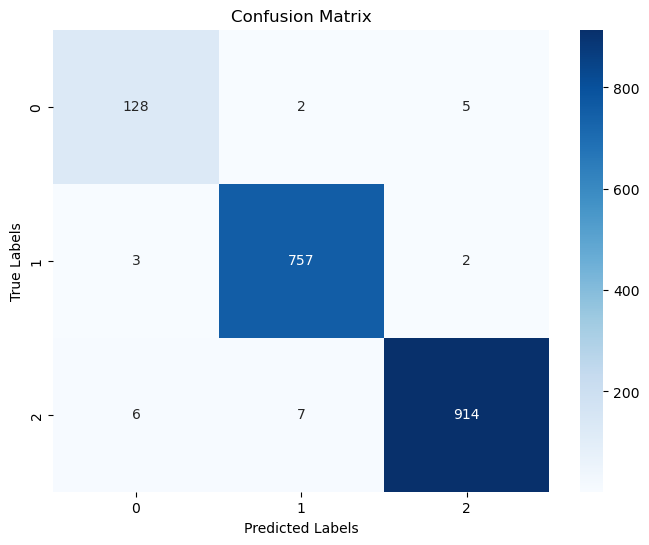

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.named_steps['classifier'].classes_,
            yticklabels=best_model.named_steps['classifier'].classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()